In [1]:
from __future__ import print_function
import torch
import numpy as np
import math, random
import matplotlib.pyplot as plt


## Calcul du gradient apres binairisation

On considere $W\in \mathbb{R}^I$ , les parametres reels.

On connait une fonction: $$h_{\epsilon}:\mathbb{R}\longrightarrow\mathbb{R} \qquad \in \mathcal{C}^1$$

$$h_{\epsilon} \sim h(t) = \begin{cases} +1, & \mbox{if } t\mbox{ >0} \\ -1, & \mbox{if } t\mbox{ <0} \end{cases}$$

On definit: $H_{\epsilon}:\mathbb{R}^I\longrightarrow\mathbb{R}^I$, tel que:

$$\forall W\in\mathbb{R}^I, \forall i \in I, H_{\epsilon}(W)_i=h_{\epsilon}(W_i)$$

On note $J_{H_{\epsilon}}(W)$ la matrice Jacobienne de $H_{\epsilon}$ en $W$, on a la differentielle:

\begin{align*}
H_{\epsilon}(W+W') &= (h_{\epsilon}(W_i+W_i'))_{i \in I}\\
                   &= \left (h_{\epsilon}(W_i)+h_{\epsilon}(W'_i)+0(\left\Vert{W'_i}\right\Vert)\right)_{i\in I}
\end{align*}

Donc: $$J_{H_{\epsilon}}(W):  \mathbb{R}^I\longrightarrow\mathbb{R}^I $$

$$W' \longmapsto \left(h'_{\epsilon}(W_i)W'_i\right)_{i\in I}$$

Si on le represente comme une matrice, c'est une matrice diagonale avec les $(h'_{\epsilon}(W'_i))_{i\in I}$ sur la diagonale.

On considere: $$f: \mathbb{R}^I\mapsto \mathbb{R} $$

consistant a calculer la somme des cout des erreurs pour l'echantillon, en $W\in \mathbb{R}^I$. On suppose $f$ etant \mathcal{C}^1

On considere: $$f_{\epsilon}: \mathbb{R}^I \mapsto \mathbb{R}$$ definit par:
$$f_{\epsilon}(W) = f(H_{\epsilon}(W))$$

On a donc $\forall W,W' \in \mathbb{R}^I$:

\begin{align*}
f_{\epsilon}(W+W') &= f(H_{\epsilon}(W+W'))\\
                   &= f\left(H_{\epsilon}(W) + J_{H_{\epsilon}}(W) (W') + 0 \left(\left\Vert W'\right\Vert\right)\right)\\
                   &= f_{\epsilon}(W) + \langle\nabla f(H_{\epsilon}(W)),J_{H_{\epsilon}}(W)(W')\rangle + 0\left(\left\Vert W'\right\Vert\right)
\end{align*}


Ou $\nabla f(H_{\epsilon}(W))$ est simplement le resultat de la Back-Propagation applique avec poid $H_{\epsilon}(W)$.

Finalement, on a:
$$\langle\nabla \left(H_{\epsilon}(W)\right),J_{H}(W)(W')\rangle = \sum_{i\in I} \nabla f\left(H_{\epsilon}(W)\right)_i h'_{\epsilon}(W_i)W'_i$$

Ainsi:

$$\nabla f_{\epsilon}(W)_i=\nabla f(H_\epsilon(W))_i h'_{\epsilon}(W_i)$$

## Set-up training data and validation data

In [74]:
np.random.seed(1000) 
NUM_HIDDEN_NODES = 20
NUM_EXAMPLES = 1000
TRAIN_SPLIT = .9
NUM_EPOCHS = 5000

In [75]:
function_to_learn = lambda x: np.sin(x) + 0.1*np.random.randn(*x.shape)

In [76]:
all_x = np.float32(np.random.uniform(-2*np.pi, 2*np.pi, (1, NUM_EXAMPLES))).T

In [77]:
np.random.shuffle(all_x)

In [78]:
train_size = int(NUM_EXAMPLES*TRAIN_SPLIT)

trainx = all_x[:train_size]
trainy = function_to_learn(trainx)

In [79]:
testx = all_x[train_size:]
testy = function_to_learn(testx)

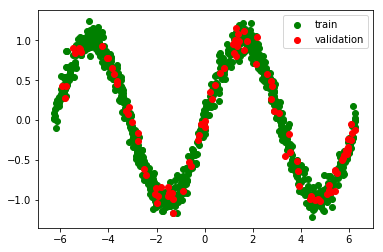

In [136]:
plt.figure(1)
plt.scatter(trainx, trainy, c='green', label='train')
plt.scatter(testx, testy, c='red', label='validation')
plt.legend()
plt.show()

In [81]:
# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
# from (https://github.com/jcjohnson/pytorch-examples)
N, D_in, H, D_out = NUM_EXAMPLES, 1, NUM_HIDDEN_NODES, 1

In [82]:
import torch
from torch.autograd import Variable
import torch.nn.init as init
import torch.nn.functional as F

dtype = torch.FloatTensor

## Neural net

In [83]:
class Net(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(Net, self).__init__()
        self.w1 = torch.nn.Linear(D_in, H)
        self.w2 = torch.nn.Linear(H, D_out)

    def forward(self, x):
        h_relu = F.tanh(self.w1(x).clamp(min=0))
        y_pred = self.w2(h_relu)
        return y_pred

In [84]:
x = Variable(torch.FloatTensor(trainx))
y = Variable(torch.FloatTensor(trainy))

In [95]:
model = Net(D_in, H, D_out)

In [126]:
for module in model.modules():
    if hasattr(module, 'weight') and not module.weight is None:
        if not ('BatchNorm' in module.__class__.__name__):
            #need to be placed in constraints
            #init.xavier_uniform_(module.weight, gain=1)
        else:
            init.constant_(module.weight, 1)
    if hasattr(module, 'bias'):
        if module.bias is not None:
            init.constant_(module.bias, 0)

In [140]:
criterion = torch.nn.MSELoss(size_average=False)
# need to choose a loss function
optimizer = torch.optim.SGD(model.parameters(), lr=1e-5)
# need to modify the weight constraints

C:\Users\Eway\Anaconda3\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [90]:
for t in range(NUM_EPOCHS):
    
    optimizer.zero_grad()

    y_pred = model(x)
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()
        
print(t, loss.item())

C:\Users\Eway\Anaconda3\lib\site-packages\torch\nn\functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


4999 58.92702865600586


In [91]:
x = Variable(torch.FloatTensor(testx))
y = Variable(torch.FloatTensor(testy))
y_pred = model(x)


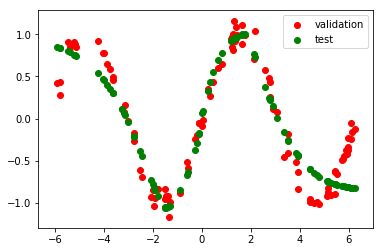

In [94]:
plt.figure(1)
plt.scatter(testx, testy, c='red', label='validation')
plt.scatter(testx, y_pred.data.numpy(), c='green', label='test')
plt.legend()